## Clean Data Science Job Posting data on Linkedin

In [1]:
import pandas as pd
from thefuzz import process # Levenshtein algorithm
import matplotlib.pyplot as plt

In [2]:
# Read csv files and drop unnecessary columns
posting = pd.read_csv('job_postings.csv')
posting = posting.drop(['last_processed_time','last_status','first_seen','got_summary','got_ner','is_being_worked','company','search_city','search_position'],axis=1)

# print job_level requirements in different searching countries
print(posting.groupby(['job_level','search_country']).size())


job_level   search_country
Associate   Australia           20
            Canada              49
            United Kingdom     115
            United States     1114
Mid senior  Australia          281
            Canada             581
            United Kingdom     880
            United States     9177
dtype: int64


In [3]:
# Merge job skills with job postings of junior-level positions and clean job titles
skill = pd.read_csv('job_skills.csv')

common_job_titles = ['Data Analyst','Data Engineer','Data Scientist','Machine Learning Engineer','Data Entry Specialist','Data Center Technician']

top_ten_associates = []
top_ten_seniors = []

for level in posting['job_level'].unique():
    df = pd.merge(posting[posting['job_level']==level],skill,how='left',on='job_link')
    for title in common_job_titles:
        df.loc[df['job_title'].str.contains(title), 'job_title'] = title
    
    # Print top 10 most popular job titles
    print(f'Top 10 most demanding job titles in {level} level \n{df.groupby(["job_title"]).size().sort_values(ascending=False).head(10)}')
    
    # Retrieve the top 10 most demanding job titles
    if level == 'Associate':
        top_ten_associates = df.groupby(['job_title']).size().sort_values(ascending=False).iloc[0:10].index.to_list()
    elif level == 'Mid senior':
        top_ten_seniors = df.groupby(['job_title']).size().sort_values(ascending=False).iloc[0:10].index.to_list()
    else: print("Please check syntax")


Top 10 most demanding job titles in Mid senior level 
job_title
Data Engineer                                               1629
Data Analyst                                                1522
Data Scientist                                               723
Machine Learning Engineer                                    440
Senior MLOps Engineer                                        138
Data Architect                                               110
Manager, Data Loss Prevention (DLP) Engineer (Symantec)       57
Principal Associate, Data Loss Prevention (DLP) Engineer      53
Senior Database Administrator                                 47
Senior MLS Engineer, Autonomous Driving Startup               45
dtype: int64
Top 10 most demanding job titles in Associate level 
job_title
Data Analyst                                321
Data Engineer                                96
Data Scientist                               80
Machine Learning Engineer                    21
Data Center Techni

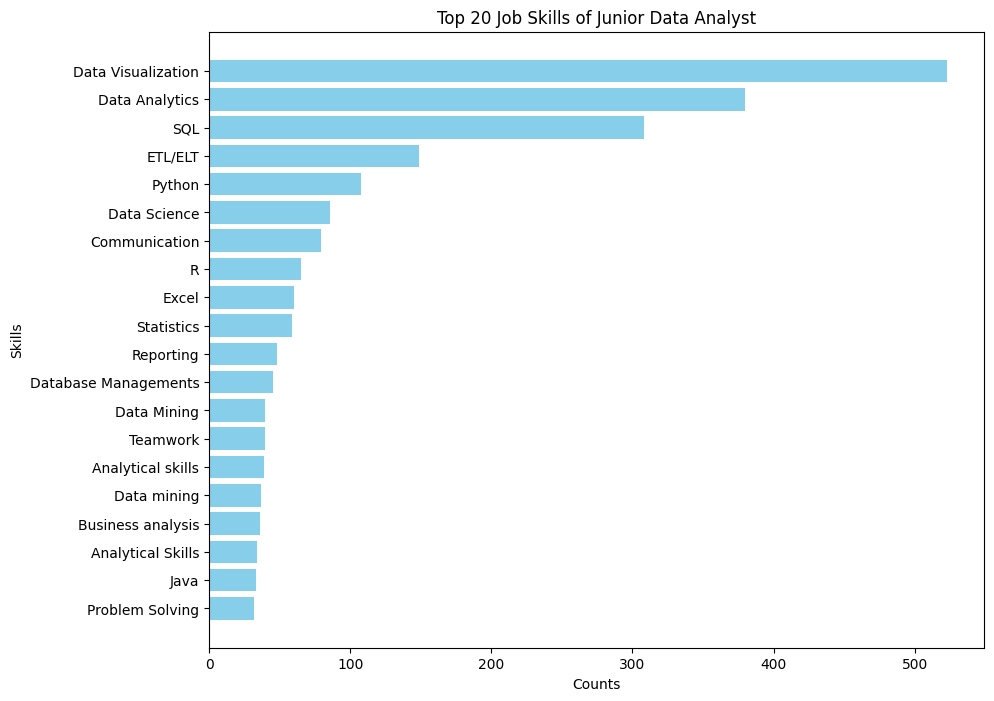

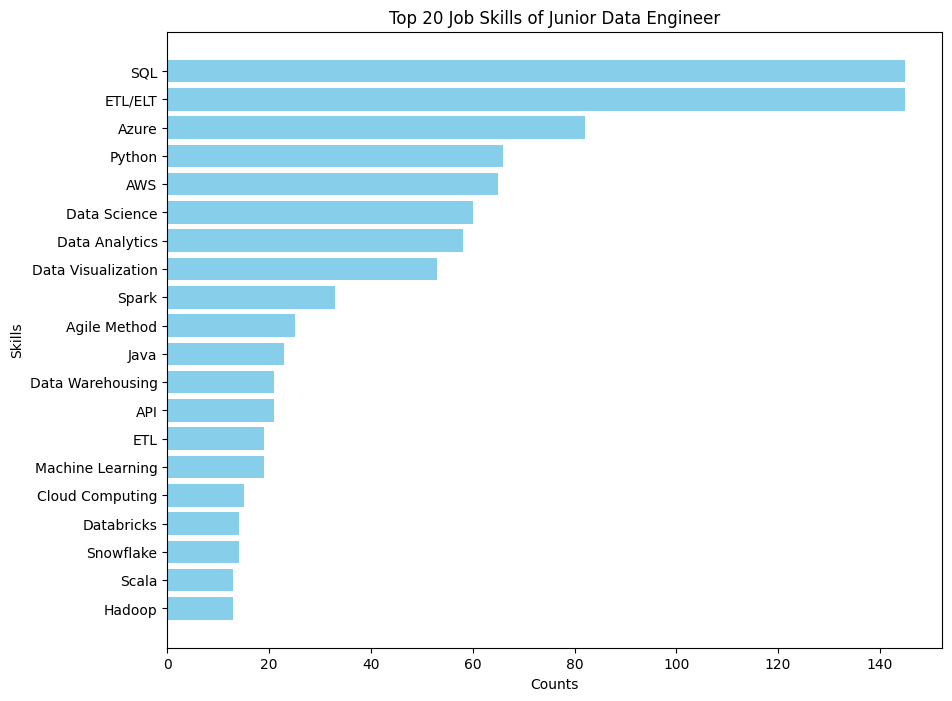

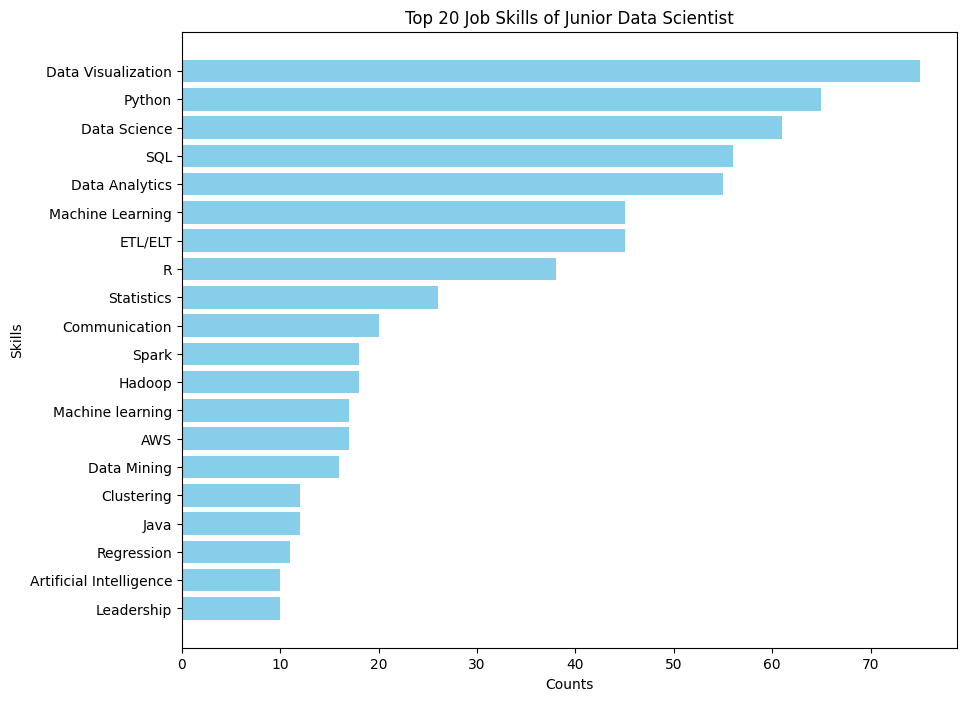

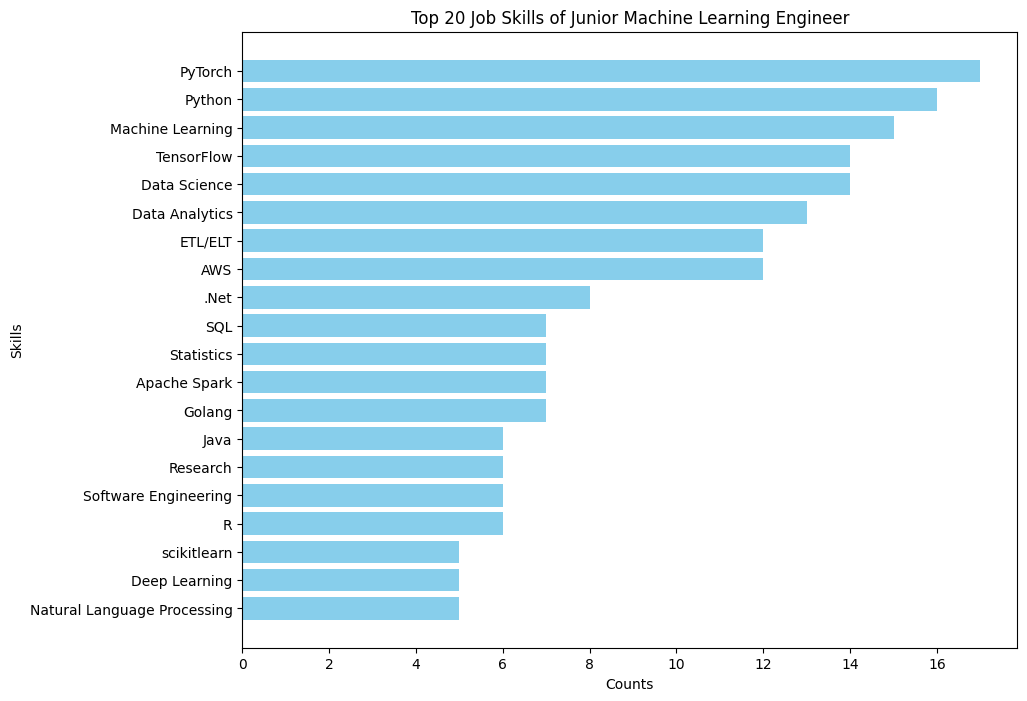

In [4]:
# Extract top four associate job titles with corresponding job skills
top_four_associates = top_ten_associates[0:4]

for title in top_four_associates:
    top_df = df.loc[df['job_title'].str.contains(title), :]
    skills_df = top_df['job_skills'].apply(lambda x: x.split(', ')).apply(pd.Series)
    skills_df = skills_df.fillna('')
    
    # Count existing job skills
    cols_count = {}
    for row in [skills_df.iloc[i,:].tolist() for i in range(0,len(skills_df))]:
        for entry in row:
            if entry in cols_count.keys():
                cols_count[entry] += 1
            else:
                cols_count[entry] = 1

    # Store the unique values of cuisine_type in unique_types
    unique_types = cols_count.keys()

    # Function to clean DataFrame based on similarity scores
    def clean_dataframe(df, threshold=80):
        # Count occurrences of each entry
        cols_count = df.stack().value_counts().to_dict()

        # Calculate similarity of skills
        skills = ['Data Analysis','Data Analytics', 'Data Visualization', 'Tableau', 'Power BI', 'SQL','.Net','A/B Testing','Business Intelligence','Database Management','Data Science']

        for skill in skills:
            matches = process.extract(skill, cols_count.keys())
            # Iterate through the list of matches
            for match in matches:
                # Check whether the similarity score is greater than or equal to threshold
                if match[1] >= threshold:
                    # Replace the matched entry in DataFrame
                    df.replace(match[0], skill, inplace=True)

        return df


    # Applying cleaning function to DataFrame and some manual cleaning
    dirty_df = clean_dataframe(skills_df)
    dirty_df = dirty_df.replace('.*AWS.*', 'AWS', regex=True)\
                        .replace('.*Amazon.*', 'AWS', regex=True)\
                        .replace('.*Agile.*', 'Agile Method', regex=True)\
                        .replace('.*SQL.*', 'SQL', regex=True)\
                        .replace('.*API.*', 'API', regex=True)\
                        .replace('.*Azure.*', 'Azure', regex=True)\
                        .replace('.*Tableau.*', 'Data Visualization', regex=True)\
                        .replace('.*Power BI.*', 'Data Visualization', regex=True)\
                        .replace('.*Business Intelligence*', 'Data Visualization', regex=True)\
                        .replace('.*Data Visualisation*', 'Data Visualization', regex=True)\
                        .replace('.*Data Integration*', 'ETL/ELT', regex=True)\
                        .replace('.*Computer Science*', 'ETL/ELT', regex=True)\
                        .replace('.*Data validation*', 'ETL/ELT', regex=True)\
                        .replace('.*Data collection*', 'ETL/ELT', regex=True)\
                        .replace('.*Data consistency*', 'ETL/ELT', regex=True)\
                        .replace('.*Data integrity*', 'Data Analytics', regex=True)\
                        .replace('.*Data Analysis*', 'Data Analytics', regex=True)\
                        .replace('.*Data Exploration*', 'Data Analytics', regex=True)\
                        .replace('.*Extraction*', 'ETL/ELT', regex=True)\
                        .replace('.*Database*', 'Database Management', regex=True)\
                        .replace('.*Data Engineering*', 'ETL/ELT', regex=True)\
                        .replace('.*Data Wrangling*', 'ETL/ELT', regex=True)\
                        .replace('.*Data Pipelines*', 'ETL/ELT', regex=True)\
                        .replace('.*Data Security*', 'ETL/ELT', regex=True)\
                        .replace('.*Data Modeling*', 'ETL/ELT', regex=True)\
                        .replace('.*Data Management*', 'ETL/ELT', regex=True)\
                        .replace('.*python*', 'Python', regex=True)

    # To count cleaned skills again
    count_clean = {}
    for row in [dirty_df.iloc[i,:].tolist() for i in range(0,len(dirty_df))]:
        for entry in row:
            if entry in count_clean.keys():
                count_clean[entry] += 1
            else:
                count_clean[entry] = 1

    # To simplify count results            
    clean_df = pd.DataFrame.from_dict(count_clean,orient='index')
    clean_df = clean_df.reset_index()
    clean_df.rename(columns={'index':'skill',0:'counts'},inplace = True)
    # To exclude empty strings
    clean_df_sorted = clean_df[clean_df['skill'] != ''].sort_values(by='counts', ascending=False)

    # Drawing the results with bar charts
    plt.figure(figsize=(10, 8))
    plt.barh(clean_df_sorted.head(20)['skill'], clean_df_sorted.head(20)['counts'], color='skyblue')
    plt.xlabel('Counts')
    plt.ylabel('Skills')
    plt.title(f'Top 20 Job Skills of Junior {title}')
    plt.gca().invert_yaxis()  # To display the highest count at the top
    plt.show()